In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import math
%matplotlib inline
import matplotlib as plt

In [3]:
negative_with_seq = pd.read_csv("./data/negative_examples.csv")
positive_with_seq = pd.read_csv("./data/positive_examples.csv")

In [6]:
n = positive_with_seq["seq_new"].apply(lambda x: True if "N" in x else False)
np.where(n == True)

(array([ 15218,  15223,  15224, ..., 153676, 153677, 153678]),)

In [7]:
bases = dict(zip("ACGTN", [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]))
bases 


{'A': [1, 0, 0, 0, 0],
 'C': [0, 1, 0, 0, 0],
 'G': [0, 0, 1, 0, 0],
 'T': [0, 0, 0, 1, 0],
 'N': [0, 0, 0, 0, 1]}

In [9]:
X_positive = []
def encode(row):
    result = []
    for base in row:
        result.append(bases[base])
        
    X_positive.append(result)
positive_with_seq["seq_new"].apply(encode)
X_positive[0][0]

[1, 0, 0, 0, 0]

In [11]:
X_negative = []
def encode_neg(row):
    result = []
    for base in row:
        result.append(bases[base])
        
    X_negative.append(result)
negative_with_seq["seq_new"].apply(encode_neg)
X_negative[0][0]

[0, 0, 0, 1, 0]

In [19]:
features = np.concatenate((X_positive, X_negative), axis=0)
features.shape

(166348, 400, 5)

In [25]:
d = [bases["A"],bases["C"]]
e = [bases["A"],bases["C"], bases["A"], bases["C"]]
e

[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0]]

In [26]:
test_con = np.concatenate((d, e), axis=0)
test_con

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [27]:
test_con.shape

(6, 5)

In [28]:
Y_pos = [[1]] * len(X_positive)
Y_neg = [[0]] * len(X_negative)

In [29]:
labels = np.concatenate((Y_pos, Y_neg), axis=0)

In [30]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(features,
                                                    labels,
                                                    test_size=0.33,
                                                    random_state=42)


In [31]:
X_train.shape

(111453, 400, 5)

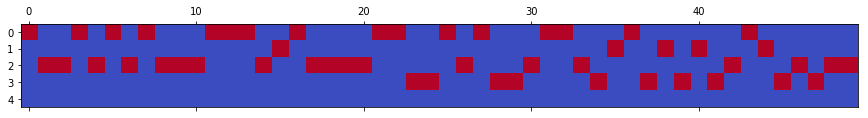

In [94]:
plt.pyplot.figure(figsize=(15, 5))
plt.pyplot.matshow(X_train[999,:50,:].transpose(), vmin=0, vmax=1, cmap=plt.pyplot.cm.coolwarm, fignum=0)


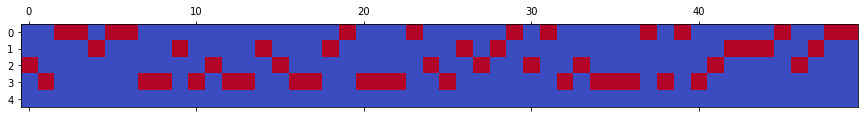

In [95]:
plt.pyplot.figure(figsize=(15, 5))
plt.pyplot.matshow(X_train[998,:50,:].transpose(), vmin=0, vmax=1, cmap=plt.pyplot.cm.coolwarm, fignum=0)


In [88]:
X_test.shape

(54895, 400, 5)

In [89]:
train_data = X_train.reshape([111453, 2000])
train_labels = y_train
eval_data = X_test.reshape([54895, 2000])
eval_labels = y_test

layer_1_nodes = 50
layer_2_nodes = 100
layer_3_nodes = 50
learning_rate = 0.001
training_epochs = 100
number_of_outputs = 1
number_of_inputs = 2000

In [90]:
train_data.shape

(111453, 2000)

In [91]:

tf.reset_default_graph()
# Input Layer
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, shape=(None, number_of_inputs), name="X")

# Layer 1
with tf.variable_scope('layer_1'):
    weights = tf.get_variable("weights1", shape=[number_of_inputs, layer_1_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases1", shape=[layer_1_nodes], initializer=tf.zeros_initializer())
    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):
    weights = tf.get_variable("weights2", shape=[layer_1_nodes, layer_2_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases2", shape=[layer_2_nodes], initializer=tf.zeros_initializer())
    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):
    weights = tf.get_variable("weights3", shape=[layer_2_nodes, layer_3_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases3", shape=[layer_3_nodes], initializer=tf.zeros_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output Layer
with tf.variable_scope('output'):
    weights = tf.get_variable("weights4", shape=[layer_3_nodes, number_of_outputs], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases4", shape=[number_of_outputs], initializer=tf.zeros_initializer())
    prediction = tf.matmul(layer_3_output, weights) + biases

# Section Two: Define the cost function of the neural network that will be optimized during training

with tf.variable_scope('cost'):
    Y = tf.placeholder(tf.float32, shape=(None, 1), name="Y")
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

# Section Three: Define the optimizer function that will be run to optimize the neural network

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Create a summary operation to log the progress of the network
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
RUN_NAME = "run 1 with 50 nodes"
# Initialize a session so that we can run TensorFlow operations
with tf.Session() as session:

    # Run the global variable initializer to initialize all variables and layers of the neural network
    session.run(tf.global_variables_initializer())

    # Create log file writers to record training progress.
    # We'll store training and testing log data separately.
    training_writer = tf.summary.FileWriter("./logs/{}/training".format(RUN_NAME), session.graph)
    testing_writer = tf.summary.FileWriter("./logs/{}/testing".format(RUN_NAME), session.graph)

    # Run the optimizer over and over to train the network.
    # One epoch is one full run through the training data set.
    for epoch in range(training_epochs):

        # Feed in the training data and do one step of neural network training
        session.run(optimizer, feed_dict={X: train_data, Y: train_labels})

        # Every few training steps, log our progress
        if epoch % 5 == 0:
            # Get the current accuracy scores by running the "cost" operation on the training and test data sets
            training_cost, training_summary = session.run([cost, summary], feed_dict={X: train_data, Y:train_labels})
            testing_cost, testing_summary = session.run([cost, summary], feed_dict={X: eval_data, Y:eval_labels})
    
            # Write the current training status to the log files (Which we can view with TensorBoard)
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)
    
            # Print the current training status to the screen
            print("Epoch: {} - Training Cost: {}  Testing Cost: {}".format(epoch, training_cost, testing_cost))

    # Training is now complete!

    # Get the final accuracy scores by running the "cost" operation on the training and test data sets
    final_training_cost = session.run(cost, feed_dict={X: train_data, Y: train_labels})
    final_testing_cost = session.run(cost, feed_dict={X: eval_data, Y: eval_labels})

    print("Final Training cost: {}".format(final_training_cost))
    print("Final Testing cost: {}".format(final_testing_cost))

Epoch: 0 - Training Cost: 0.33564919233322144  Testing Cost: 0.33652159571647644


Epoch: 5 - Training Cost: 0.09372221678495407  Testing Cost: 0.09169992804527283


Epoch: 10 - Training Cost: 0.09237436950206757  Testing Cost: 0.08941369503736496


Epoch: 15 - Training Cost: 0.07734972983598709  Testing Cost: 0.07512230426073074


Epoch: 20 - Training Cost: 0.072813019156456  Testing Cost: 0.07045739144086838


Epoch: 25 - Training Cost: 0.07167725265026093  Testing Cost: 0.06927438825368881


Epoch: 30 - Training Cost: 0.0713334009051323  Testing Cost: 0.06926854699850082


Epoch: 35 - Training Cost: 0.06992018222808838  Testing Cost: 0.06757499277591705


Epoch: 40 - Training Cost: 0.0689697116613388  Testing Cost: 0.06673672795295715


Epoch: 45 - Training Cost: 0.06906340271234512  Testing Cost: 0.06699341535568237


Epoch: 50 - Training Cost: 0.06848178058862686  Testing Cost: 0.06632641702890396


Epoch: 55 - Training Cost: 0.0684622973203659  Testing Cost: 0.06626429408788681


Epoch: 60 - Training Cost: 0.06819421797990799  Testing Cost: 0.06605736166238785


Epoch: 65 - Training Cost: 0.0680912584066391  Testing Cost: 0.06602340191602707


Epoch: 70 - Training Cost: 0.06799395382404327  Testing Cost: 0.06595398485660553


Epoch: 75 - Training Cost: 0.067872554063797  Testing Cost: 0.06583758443593979


Epoch: 80 - Training Cost: 0.06778432428836823  Testing Cost: 0.06575614213943481


Epoch: 85 - Training Cost: 0.06770839542150497  Testing Cost: 0.06569990515708923


Epoch: 90 - Training Cost: 0.06763370335102081  Testing Cost: 0.06565184146165848


Epoch: 95 - Training Cost: 0.06756138801574707  Testing Cost: 0.06561208516359329


Final Training cost: 0.06750517338514328
Final Testing cost: 0.06558830291032791


tensorflow.python.framework.ops.Tensor